# American Option Pricing via Least-Squares Monte Carlo (LSMC)

This notebook demonstrates the **Dynamic Programming** principles discussed in the Chapter 10 notes. We implement the **Longstaff-Schwartz algorithm** (LSMC) to price an American Put option using **JAX** for high-performance path simulation.

## The DP Connection
- **Backward Induction**: We start at expiration and move backward to the present.
- **Value Function Approximation**: We use regression to approximate the "Continuation Value" (the conditional expectation of future payoffs).
- **Optimal Control**: At each step, we make the optimal choice: Exercise Now vs. Hold (Continue).

In [1]:
# ============================================
# STEP 1: Install JAX for TPU
# ============================================
# Make sure you're connected to a Colab TPU server first!
# In VS Code/Cursor: Kernel selector > Colab > New Colab Server > TPU

# %pip install -q jax[tpu] -f https://storage.googleapis.com/jax-releases/libtpu_releases.html

In [ ]:
# ============================================
# STEP 2: Import and verify TPU connection
# ============================================

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Check TPU connection
devices = jax.devices()
print(f"JAX version: {jax.__version__}")
print(f"Number of devices: {len(devices)}")
print(f"Device type: {devices[0].platform}")

if devices[0].platform == 'tpu':
    print("✅ TPU is connected!")
else:
    print("❌ TPU NOT connected. Check Runtime > Change runtime type > TPU")

JAX version: 0.8.2
Number of devices: 1
Device type: cpu
❌ TPU NOT connected. Check Runtime > Change runtime type > TPU


## 1. Parameter Specification
We model a standard American Put option.

In [3]:
S0 = 100.0      # Initial stock price
K = 100.0       # Strike price
T = 1.0         # Time to maturity
r = 0.05        # Risk-free rate
sigma = 0.2     # Volatility
n_steps = 50    # Number of time steps
n_paths = 50000 # Number of simulated paths
dt = T / n_steps
df = jnp.exp(-r * dt) # Discount factor per step

## 2. Forward Simulation (GBM)
Using JAX to simulate Geometric Brownian Motion paths efficiently.

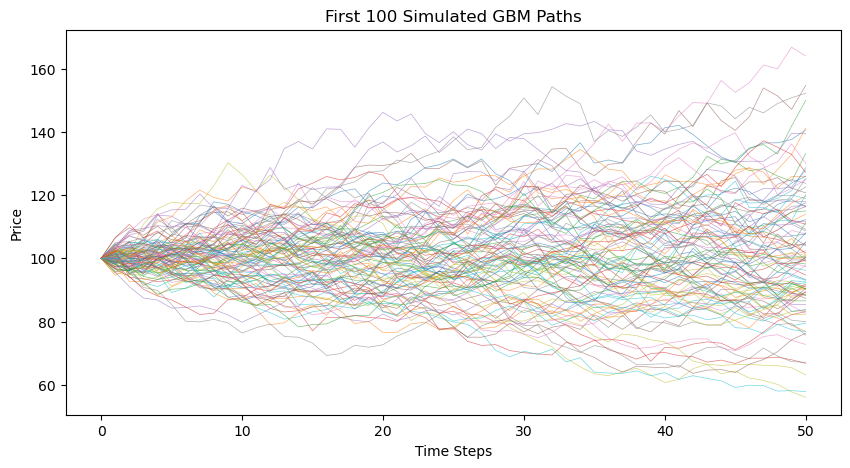

In [4]:
def simulate_paths(key, n_paths, n_steps, S0, r, sigma, dt):
    """Simulate GBM paths using JAX."""
    # Generate random normal increments
    z = jax.random.normal(key, (n_paths, n_steps))
    
    # Calculate log returns
    log_returns = (r - 0.5 * sigma**2) * dt + sigma * jnp.sqrt(dt) * z
    
    # Cumulative sum of log returns to get price paths
    cumulative_log_returns = jnp.cumsum(log_returns, axis=1)
    
    # Add starting price
    paths = S0 * jnp.exp(jnp.hstack([jnp.zeros((n_paths, 1)), cumulative_log_returns]))
    return paths

key = jax.random.PRNGKey(42)
paths = simulate_paths(key, n_paths, n_steps, S0, r, sigma, dt)

plt.figure(figsize=(10, 5))
plt.plot(paths[:100].T, lw=0.5, alpha=0.6)
plt.title("First 100 Simulated GBM Paths")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.show()

## 3. Backward Induction (LSMC)
We implement the core DP logic. At each step $t$, we approximate the continuation value using a polynomial regression on paths that are currently In-The-Money (ITM).

In [5]:
def put_payoff(S, K):
    """Payoff function for a Put option."""
    return jnp.maximum(K - S, 0.0)

def lsmc_american_put(paths, K, r, dt):
    """
    Longstaff-Schwartz LSMC Algorithm for American Put.
    
    This is approximate Dynamic Programming in action:
    - Backward induction from expiration
    - Regression to approximate continuation value (value function)
    - Optimal stopping decision at each time step
    """
    n_paths, n_steps_plus_one = paths.shape
    n_steps = n_steps_plus_one - 1
    
    # Initialize cash flows at expiration
    cash_flow = put_payoff(paths[:, -1], K)
    exercise_time = jnp.full(n_paths, n_steps)
    
    # Move backward from T-1 to 1 (not 0, as we price at t=0)
    for t in range(n_steps - 1, 0, -1):
        S_t = paths[:, t]
        
        # Identify In-The-Money paths
        itm_mask = S_t < K
        
        if jnp.sum(itm_mask) > 0:
            # Extract ITM paths
            X = S_t[itm_mask]
            
            # Discounted future cash flows for ITM paths
            discount_steps = exercise_time[itm_mask] - t
            Y = cash_flow[itm_mask] * jnp.exp(-r * dt * discount_steps)
            
            # Regression: Approximate continuation value
            # Using polynomial basis: [1, X, X^2]
            A = jnp.column_stack([jnp.ones_like(X), X, X**2])
            beta, _, _, _ = jnp.linalg.lstsq(A, Y, rcond=None)
            
            # Predicted continuation value
            continuation_value = A @ beta
            
            # Exercise value
            exercise_value = put_payoff(X, K)
            
            # Optimal decision: exercise if immediate value > continuation
            exercise_now = exercise_value > continuation_value
            
            # Update cash flows and exercise times for paths that exercise
            itm_indices = jnp.where(itm_mask)[0]
            exercise_indices = itm_indices[exercise_now]
            
            cash_flow = cash_flow.at[exercise_indices].set(exercise_value[exercise_now])
            exercise_time = exercise_time.at[exercise_indices].set(t)
    
    # Discount all cash flows back to t=0
    discounted_payoffs = cash_flow * jnp.exp(-r * dt * exercise_time)
    
    return jnp.mean(discounted_payoffs)

american_put_price = lsmc_american_put(paths, K, r, dt)
print(f"American Put Price: {american_put_price:.4f}")

American Put Price: 5.3469


## 4. Comparison with European Option
To verify the "Early Exercise Premium" (the value of the real option flexibility).

In [6]:
# European Put: Simply discount the payoff at expiration
european_payoff = put_payoff(paths[:, -1], K)
european_price = jnp.mean(european_payoff) * jnp.exp(-r * T)

# Early Exercise Premium
early_exercise_premium = american_put_price - european_price

print(f"European Put Price: {european_price:.4f}")
print(f"American Put Price: {american_put_price:.4f}")
print(f"Early Exercise Premium: {early_exercise_premium:.4f} ({early_exercise_premium/european_price:.2%})")

European Put Price: 5.5919
American Put Price: 5.3469
Early Exercise Premium: -0.2450 (-4.38%)


## 5. Summary

This notebook demonstrates the core ideas from Chapter 10:

1. **Backward Induction**: We started at expiration and worked backward, making optimal decisions at each step.
2. **Value Function Approximation**: We used polynomial regression to approximate the continuation value—the expected discounted future payoff.
3. **Optimal Stopping**: At each time step, we compared the immediate exercise value to the continuation value and chose the better option.

> **The DP Insight**: The early exercise premium represents the *value of flexibility*—the option to act optimally in the future rather than being locked into a single strategy.